In [ ]:
bucket='c93435a2086644l5064089t1w643665167313-labbucket-1312fx9b30ybg'

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


Getting Data Ready:
I'll Open a CSV file containing the dataset, remove any unnecessary columns, and use LabelEncoder to encode categorical values. To start with the prediction objective.

Splitting & Uploading Data:
Train_test_split will be used to divide the dataset into training, testing, and validation sets.

Then I will transfer these datasets to a bucket on Amazon S3.

Setting Up and Teaching the Model:
Using SageMaker, I will set up an XGBoost model by specifying its hyperparameters and specifications.
Utilising the ready-made training data kept in S3, train the XGBoost model.

Model Forecast:
Then I will get the test dataset ready for forecasting and submit it to S3.

A SageMaker batch transformation process is started to enable the learned model to generate predictions.

Then obtain and save the forecast outcomes in a Pandas DataFrame.

Measures of Performance:
The performance indicators like specificity, sensitivity, ROC curve, confusion matrix, and more will be determined for model evaluation.


In [3]:
%%time

def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()


df = pd.read_csv('cropfolder/cropStats.csv',delimiter=',')

# Dropping the first and last columns
df = df.iloc[:, 1:-1]  # Selects all rows, and columns from index 1 to the second-to-last column

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['states_encoded'] = label_encoder.fit_transform(df['Location'])

# Create a new DataFrame with 'states_encoded' as the first column
new_order = ['states_encoded'] + [col for col in df if col != 'states_encoded']
df = df[new_order]

# Drop the original 'Location' column after encoding
df = df.drop('Location', axis=1)
df

# column to be predicted is 2017 column, so that comes first

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

prefix='lab3'

train_file='crop_train.csv'
test_file='crop_test.csv'
validate_file='crop_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams = {
    "num_round": "100",
    "eval_metric": "rmse",  # Evaluation metric (Root Mean Squared Error)
    "objective": "reg:squarederror",  # Objective for regression
    "silent": 1
}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)


s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f"{prefix}/batch-out/{batch_X_file}.out")
results = pd.read_csv(obj['Body'], header=None)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-06-04-12-48-714



2023-11-06 04:12:49 Starting - Starting the training job..
2023-11-06 04:13:06 Starting - Preparing the instances for training.............
2023-11-06 04:14:15 Downloading - Downloading input data......
2023-11-06 04:14:50 Training - Downloading the training image
2023-11-06 04:14:55 Training - Training image download completed. Training in progress......
2023-11-06 04:15:26 Uploading - Uploading generated training model.
2023-11-06 04:15:37 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-06-04-15-40-657


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-06-04-15-41-285


..............................
.[2023-11-06:04:20:46:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:20:46:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:20:46:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
[2023-11-06:04:20:46:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:20:46:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:20:46:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy


I will access the file 'batch-in.csv.out' in an S3 bucket via the Boto3 library.
Then convert the retrieved file into a Pandas DataFrame to obtain predictions for the year 2017.
The Root Mean Squared Error (RMSE) will be computed using the actual test labels and the predicted values.


In [4]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=[2017])

test_labels = test.iloc[:, 0]

# Calculate Root Mean Squared Error (RMSE) for regression
from sklearn.metrics import mean_squared_error
import numpy as np

# Root Mean Squared Error (RMSE) calculation
rmse = np.sqrt(mean_squared_error(test_labels, target_predicted[2017]))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 887861.5721122075


Now I will create a scatter plot to compare how the model's predicted values align with the actual test labels for the year 2017.

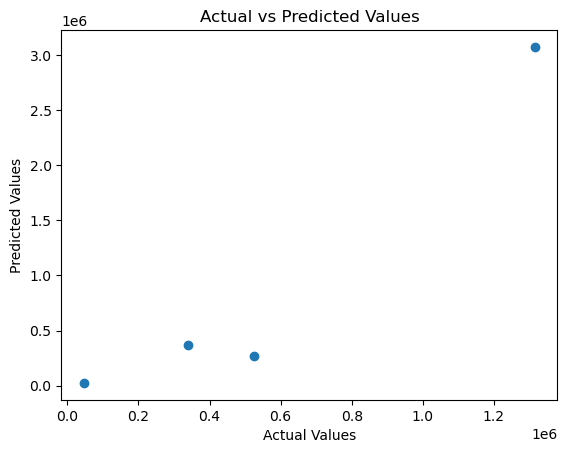

In [5]:
import matplotlib.pyplot as plt

# Assuming 'test_labels' contains the actual test labels for regression
# Assuming 'target_predicted' contains the predicted values for regression
plt.scatter(test_labels, target_predicted[2017])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


Next I will try to enhance the model performance by fine-tuning hyperparameters.

In [10]:
%%time

from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(objective='reg:squarederror',
                        eval_metric='rmse',
                        num_round=100)  # Adjust as needed

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 10),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.01, 0.3),  
                         'num_round': IntegerParameter(1, 200)
                        }

objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-231106-0434


......................................................................................................................................!
!
CPU times: user 790 ms, sys: 73.2 ms, total: 863 ms
Wall time: 11min 35s


This verifies that SageMaker's most recent Hyperparameter Tuning Job is still active. It obtains status information on the job, specifically to find out if it is running, finished, or experiencing any problems. This makes it easier for you to monitor the tuning process and watch its development.

In [11]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

The code snippet gathers information from the most recent Hyperparameter Tuning Job using SageMaker Analytics. It will create a tabular view of the tuning work outcomes in order to compare and offer insights into various models. To have a better understanding of the performance of the models, particularly the top 20.

In [12]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,31.146694,0.248224,2.615858,200.0,0.572464,sagemaker-xgboost-231106-0434-009-fe8e39c8,Completed,9.894987e+04,2023-11-06 04:44:21+00:00,2023-11-06 04:44:53+00:00,32.0
0,14.627285,0.300000,1.634631,200.0,0.865415,sagemaker-xgboost-231106-0434-010-fbf385ad,Completed,1.429365e+05,2023-11-06 04:45:09+00:00,2023-11-06 04:45:41+00:00,32.0
6,59.383977,0.270438,2.884507,39.0,0.913064,sagemaker-xgboost-231106-0434-004-194a5d70,Completed,1.503052e+05,2023-11-06 04:40:23+00:00,2023-11-06 04:40:55+00:00,32.0
9,61.409655,0.157767,2.001361,91.0,0.615797,sagemaker-xgboost-231106-0434-001-972b409a,Completed,1.800110e+05,2023-11-06 04:36:11+00:00,2023-11-06 04:38:03+00:00,112.0
8,30.218523,0.221647,3.031084,6.0,0.512132,sagemaker-xgboost-231106-0434-002-cdb9d048,Stopped,2.709356e+05,2023-11-06 04:38:15+00:00,2023-11-06 04:38:45+00:00,30.0
4,50.742761,0.142246,5.033325,3.0,1.000000,sagemaker-xgboost-231106-0434-006-7c076ef1,Completed,4.237845e+05,2023-11-06 04:41:55+00:00,2023-11-06 04:42:27+00:00,32.0
3,69.424838,0.300000,2.475086,1.0,1.000000,sagemaker-xgboost-231106-0434-007-4f0ac86c,Completed,4.341023e+05,2023-11-06 04:42:43+00:00,2023-11-06 04:43:15+00:00,32.0
5,10.445680,0.014481,1.775537,20.0,0.981767,sagemaker-xgboost-231106-0434-005-c26db55e,Completed,4.544383e+05,2023-11-06 04:41:06+00:00,2023-11-06 04:41:38+00:00,32.0
7,95.692361,0.028978,7.987275,104.0,0.618683,sagemaker-xgboost-231106-0434-003-f124f2b0,Completed,6.837118e+05,2023-11-06 04:39:38+00:00,2023-11-06 04:40:10+00:00,32.0
2,69.680738,0.300000,10.000000,142.0,0.612840,sagemaker-xgboost-231106-0434-008-c4414c3d,Completed,1.055199e+06,2023-11-06 04:43:32+00:00,2023-11-06 04:44:04+00:00,32.0


The latest tuning job is gotten here and we will indentify the best performing model for analysis

In [13]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


The best-performing model will now be loaded for further use

In [14]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2023-11-06 04:45:08 Starting - Found matching resource for reuse
2023-11-06 04:45:08 Downloading - Downloading input data
2023-11-06 04:45:08 Training - Training image download completed. Training in progress.
2023-11-06 04:45:08 Uploading - Uploading generated training model
2023-11-06 04:45:08 Completed - Resource reused by training job: sagemaker-xgboost-231106-0434-010-fbf385ad


I will use the best algorithm model chosen to configure an XGBoost model as a transformer. After then, this model is used to process data that has been saved in S3 for prediction

In [15]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-06-04-46-58-431
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-06-04-46-58-987


...................................[2023-11-06:04:52:52:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:52:52:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-06:04:52:52:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-06 04:52:53 +0000] [19] [INFO] Starting 

next I will take the prediction file "batch-in.csv.out" out of the S3 bucket, compare the file's predicted values with the test labels, and display the result to find the Root Mean Squared Error (RMSE) for regression.


In [16]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=[2017])

test_labels = test.iloc[:, 0]

# Calculate Root Mean Squared Error (RMSE) for regression
from sklearn.metrics import mean_squared_error
import numpy as np

# Root Mean Squared Error (RMSE) calculation
rmse = np.sqrt(mean_squared_error(test_labels, target_predicted[2017]))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 935798.0772953657


An XGBoost model that has been trained and fine-tuned will be deployed as an endpoint, and the model and endpoint configurations are then saved to an Amazon S3 bucket. The model artefacts will be downloaded to the local working directory.

In [ ]:
from sagemaker.serializers import CSVSerializer
import boto3

endpoint_name = 'scikit-endpoint-21'
predictor = tuned_xgb_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge',
                                   endpoint_name=endpoint_name,
                                   serializer=CSVSerializer())  # Serializer depends on the data format

# Save the endpoint configuration to S3
predictor.save('s3://your-bucket/endpoint-config/')  # Save the endpoint configuration in S3

# Define the S3 bucket and prefix where the model artifacts are saved
s3_bucket = 'scikit-bucket'
s3_prefix = 'scikit-prx'

# Save the model
model_name = 'scikit-model-21'
tuned_xgb_model.model_data = f's3://{s3_bucket}/{s3_prefix}/model.tar.gz'  # Path where the model artifacts are stored

# Save model metadata in S3
tuned_xgb_model.name = model_name
tuned_xgb_model.create_model()
tuned_xgb_model.save(f's3://{s3_bucket}/{s3_prefix}/model-config/')  # Save model metadata in S3

# Download the model artifact to the local working directory
s3 = boto3.client('s3')

# Replace 'your-bucket' and 'your-prefix' with the bucket and prefix where your model artifacts are stored
local_model_path = 'local-model/model.tar.gz'
s3.download_file(s3_bucket, f'{s3_prefix}/model.tar.gz', local_model_path)
